# Model Evaluation  

## 1. Evaluation of Hyperparameter Tuning Results
- Analysis of the results from the hyperparameter grid search for a Random Forest model.  
- The grid search is implemented with a **10-fold stratified cross-validation** using 70% of the total dataset as training data.  
- Multiple pipelines are tested, where the preprocessing steps before the classifier vary.  
- For each pipeline the best model is selected based on:  
  - **Validation metrics score** (accuracy, f1, and auc)  
  - **Difference between training and validation scores** (to assess overfitting)  
  - **Standard deviation of the validation score** (to evaluate model stability)  

##### Key Considerations
- A **large gap** between training and validation scores suggests **overfitting** (high variance), meaning the model struggles to generalize.  
- A **high standard deviation** in validation scores indicates the model is **unstable** and may not perform consistently.  
- Both factors can significantly impact the final performance on unseen test data.  
- Based on these criteria, the **best pipeline** is selected.  



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
import joblib

from sklearn.metrics import classification_report

import utils.plotting_evaluation as plot_eval
import utils.model_evaluation as model_eval

import pipelines.define_pipelines as pipeline_def
import pipelines.custom_pipeline_components as pipeline_comp





#### General Pipeline Setup

The pipeline consists of several steps that ensure proper data processing, imputation, scaling, and model evaluation:

1. **Preprocessing**: Replace `0` values with `NaN` for imputation.
2. **Standard Scaler**: Standardize features (mean=0, std=1).
3. **Imputation**: Handle missing values with strategies like:
   - Simple Imputer (mean, median)
   - KMeans-based imputation: Impute missing values using KMeans clustering, either based on all features or by considering only those groups of features with high correlation in PCA.
4. **Feature Addition**: Add KMeans clustering features to improve performance.
5. **Random Forest**: Fine-tuned with grid search to build predictive models.

For a detailed breakdown of each step, refer to the previous notebook [01_data_exploration.ipynb](./01_data_exploration.ipynb).

---

#### Pipeline Overview

| #  | Imputation                                         | KMeans Feature Added | Pipeline Name                        |
|----|----------------------------------------------------|----------------------|--------------------------------------|
| 1  | KNN Imputation based on correlated features via PCA| ✔                    | KNN with PCA                         |
| 2  | KNN Imputation based on all features               | ✔                    | KNN                                  |
| 3  | Mean Imputation                                    | ✔                    | Mean Imputation                      |
| 4  | Median Imputation                                  | ✔                    | Median Imputation                    |
| 5  | None                                               | ✘                    | No Imputation & No KMeans            |
| 6  | KNN Imputation based on PCA                        | ✘                    | KNN with PCA & No KMeans             |
| 7  | KNN Imputation                                     | ✘                    | KNN & No KMeans                      |
| 8  | Mean Imputation                                    | ✘                    | Mean Imputation & No KMeans          |
| 9  | Median Imputation                                  | ✘                    | Median Imputation & No KMeans        |

All other steps (e.g., preprocessing, standard scaler) are identical across pipelines.

---

#### Evaluation Metrics 

- **Accuracy**:
  $$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
    - might be not the best metric due to the imbalance between the classes (class 0: 65% and class 1: 35%)
- **F1 Score**:
  $$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

  - $\text{Precision} = \frac{TP}{TP + FP}$
      - Measures how many predicted positive cases are actually positive.
  - $\text{Recall} = \frac{TP}{TP + FN}$
      - Measures how many actual positive cases are correctly predicted.
      - Possibly the most important metric for diabetes prediction because missing a positive case (false negative) can be dangerous.


- **AU ROC**:
  - Measures the ability to differentiate between classes.
  - AUC close to 1 indicates a good model; near 0.5 suggests random predictions.



#### Model Selection Criteria

For each metric, the best parameters are chosen based on:

1. **Validation Metric Score**:
   - The best model is selected based on the highest validation metric score.
   - A model is considered eligible if:
     - The **difference** between the **train** and **validation** metrics is **less than 0.05**.
     - The **standard deviation** of the validation metric is **less than 0.05**.
   
   If **none of the models** meet these criteria, the model with the smallest difference between train and validation metrics (even if > 0.05) and the smallest standard deviation of the validation metric is selected.

2. **Model Selection**:
   - After applying the above criteria, the model with the **highest validation score** is chosen for each metric.
   - Finally, among the best models for each evaluation metric, the model with the **highest overall validation score** across all metrics is selected.

For each pipeline, the model parameters are fine-tuned during a grid search process to select the best combination for optimal performance.

--- 



In [2]:
# Definitions
features = ['Pregnancies', 'Glucose', 'BP', 'Skin', 'Insulin', 'BMI', 'DPF', 'Age']
scoring_metrics_grid = ["accuracy","f1", "roc_auc"] # scoring metrics used in the hyperparameter tuning
grid_results_path = "../results/hyperparameter_tuning_results" # path to directory with results of grid search 
pipeline_dict = pipeline_def.define_pipelines(features) # dict of pipelines used in the hyperparameter search
n_splits = 10 # number of folds for cross-validation in hyperparameter tuning



                        Best Model for Pipeline: KNN PCA
Best hyperparameters saved to ../src/models/best_params/knn_pca_best_params.pkl


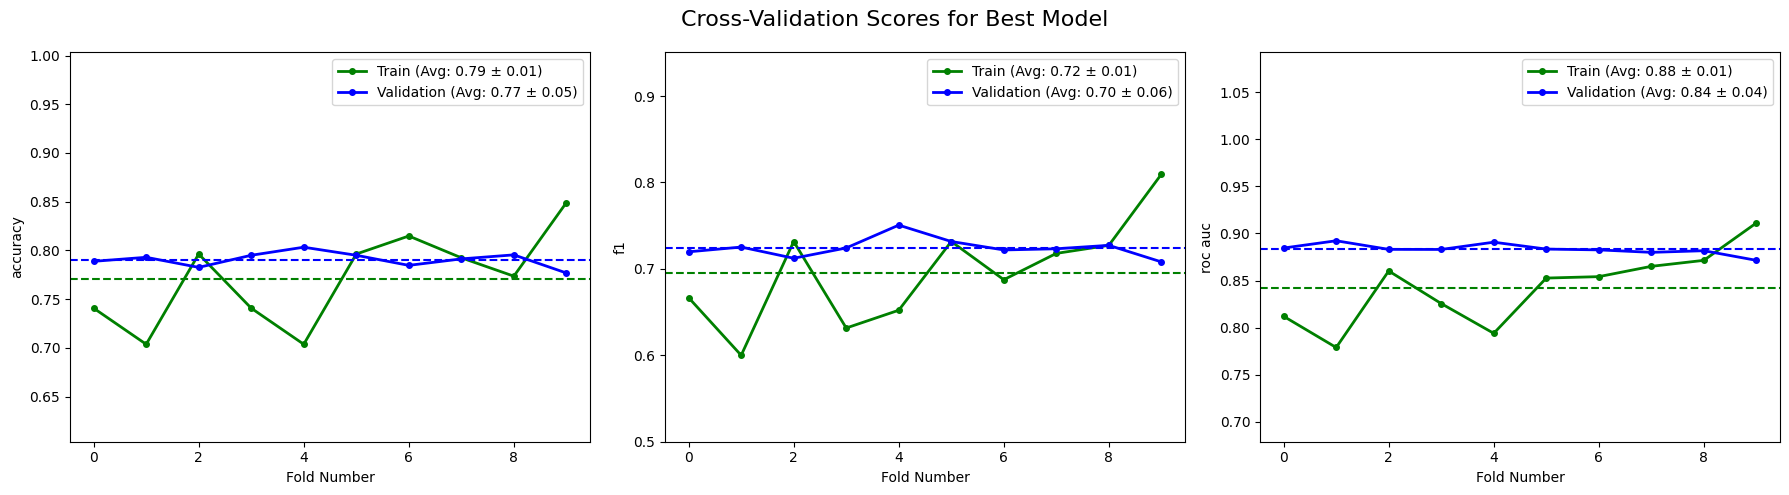


                        Best Model for Pipeline: KNN
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/knn_best_params.pkl


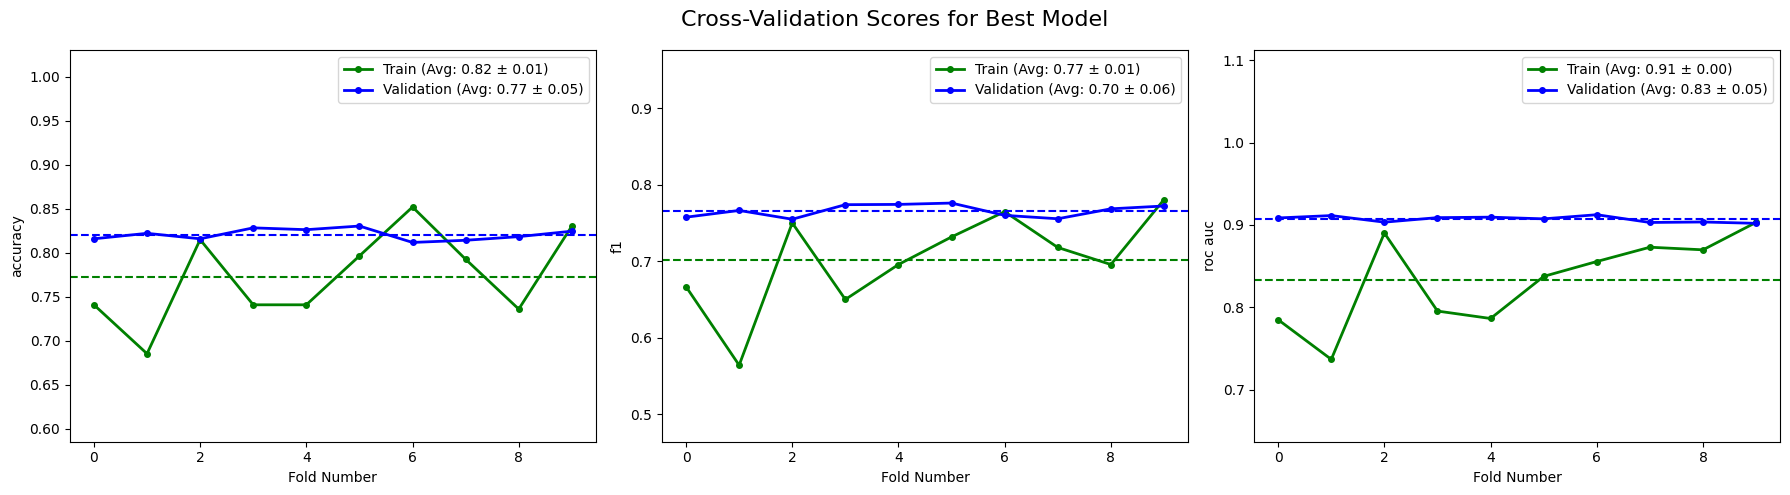


                        Best Model for Pipeline: MEAN
Best hyperparameters saved to ../src/models/best_params/mean_best_params.pkl


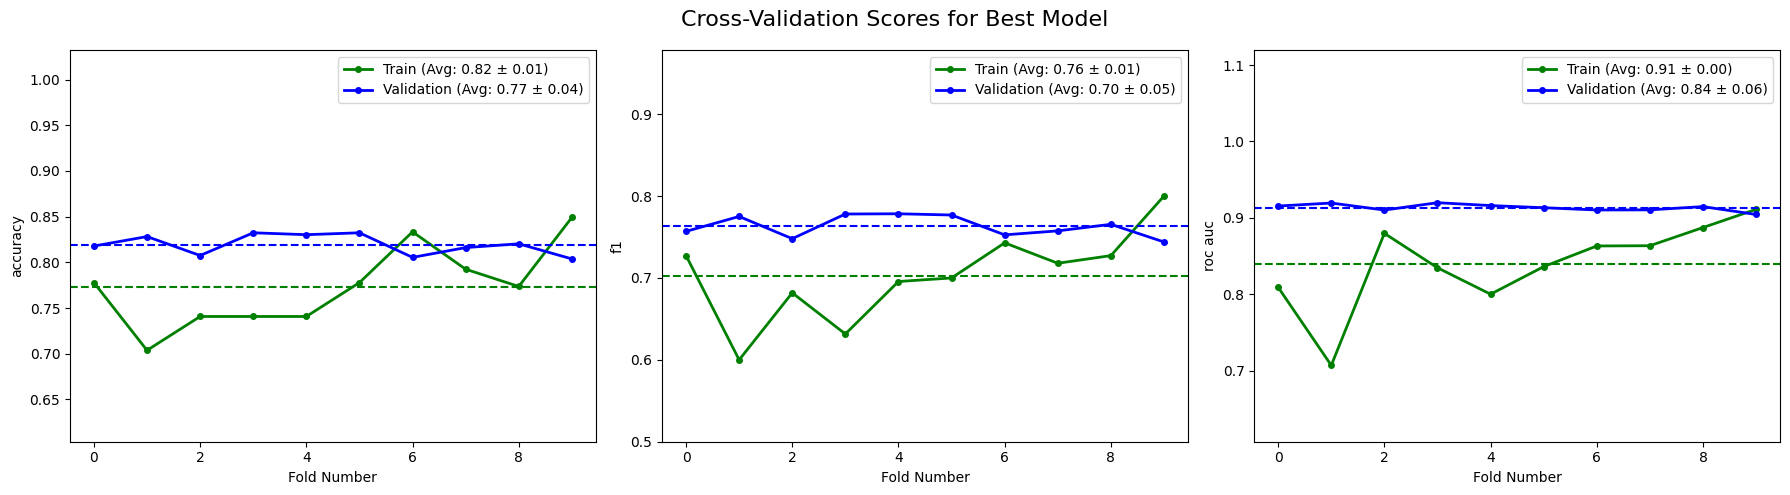


                        Best Model for Pipeline: MEDIAN
Best hyperparameters saved to ../src/models/best_params/median_best_params.pkl


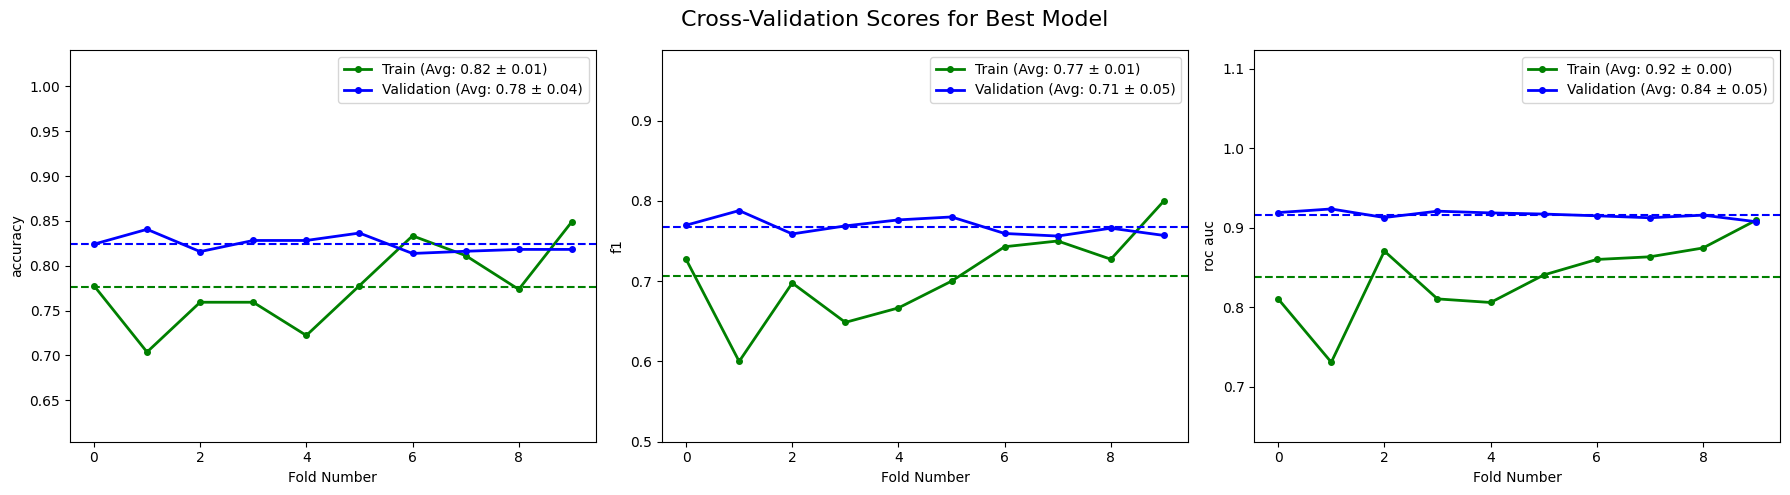


                        Best Model for Pipeline: NO IMPUTER NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/no_imputer_no_kmeans_best_params.pkl


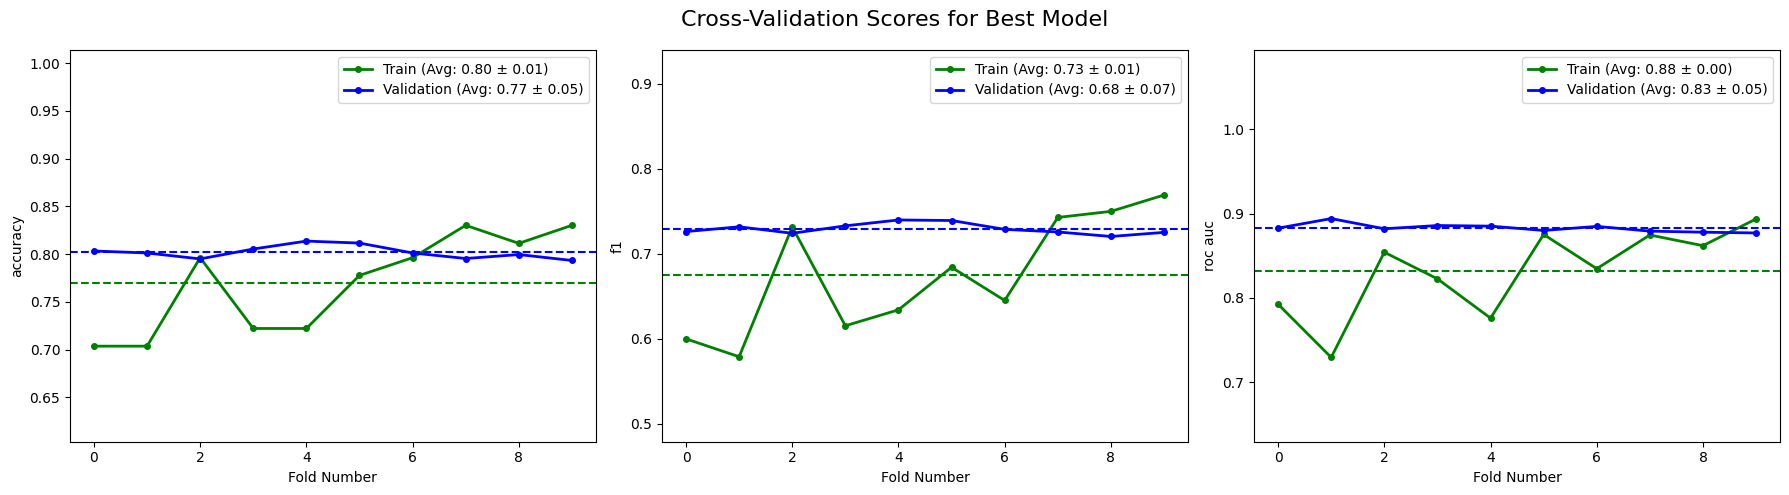


                        Best Model for Pipeline: KNN PCA NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/knn_pca_no_kmeans_best_params.pkl


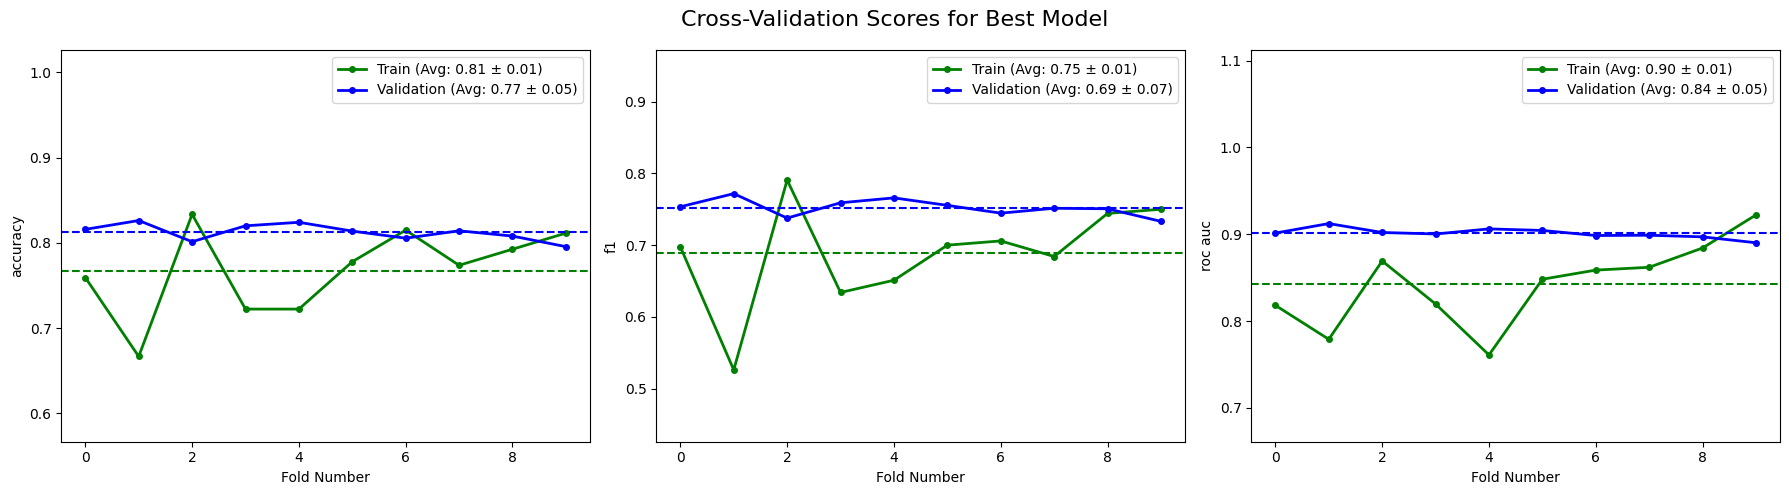


                        Best Model for Pipeline: KNN NO KMEANS
Best hyperparameters saved to ../src/models/best_params/knn_no_kmeans_best_params.pkl


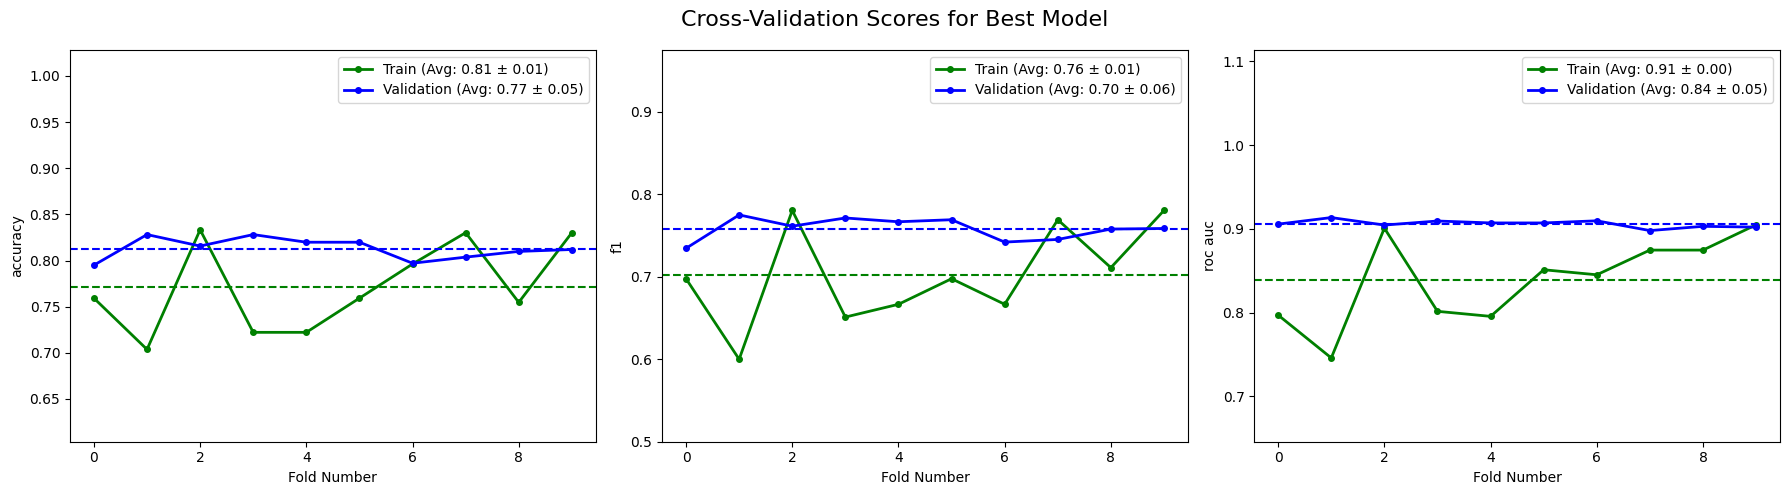


                        Best Model for Pipeline: MEAN NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/mean_no_kmeans_best_params.pkl


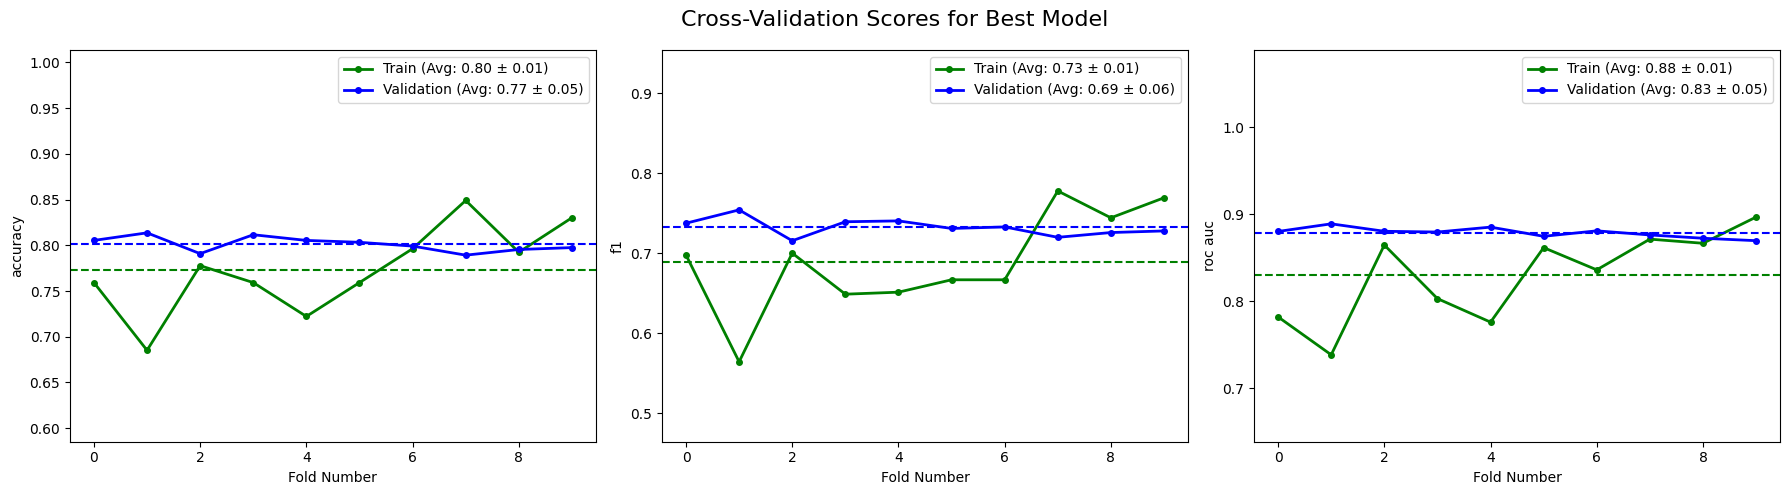


                        Best Model for Pipeline: MEDIAN NO KMEANS
[Scoring metric: f1] No models met the train - val diff < 0.05 and std val < 0.05 criteria. Selecting no model for this metric.
Best hyperparameters saved to ../src/models/best_params/median_no_kmeans_best_params.pkl


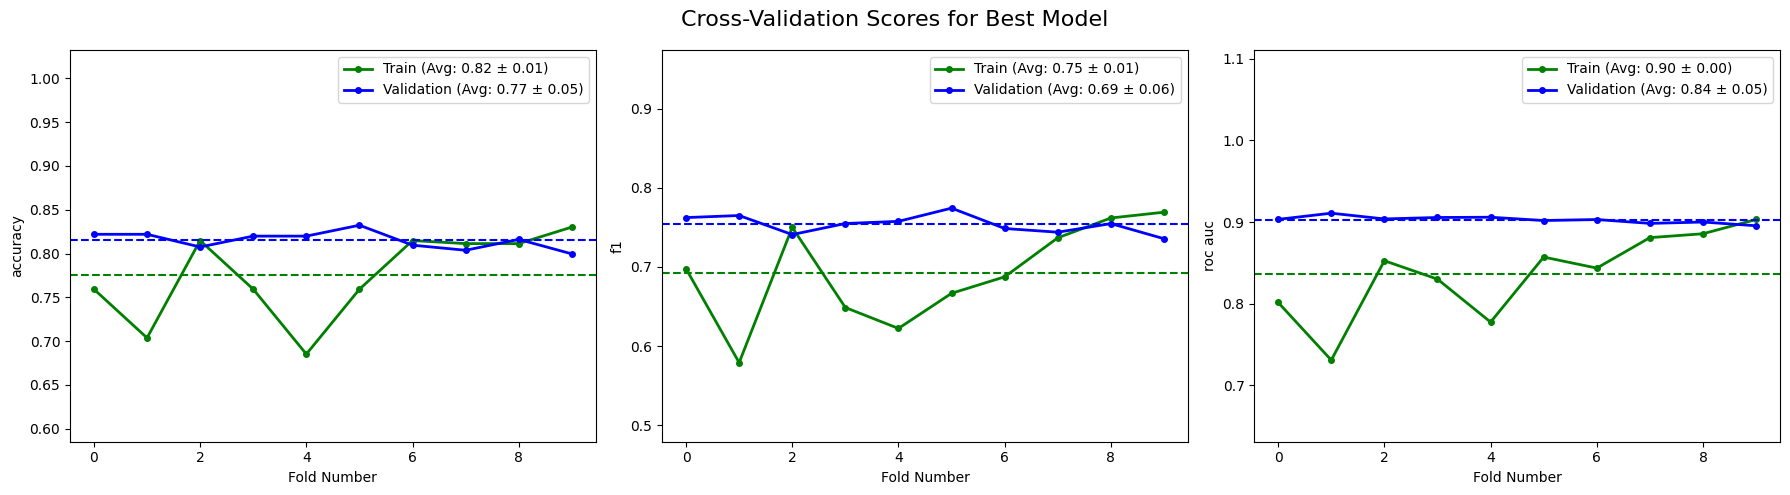

In [3]:
columns = [f"{stat}_{metric}" for metric in scoring_metrics_grid for stat in ['mean_train', 'mean_test', 'std_train', 'std_test']]
best_models_df = pd.DataFrame(columns = columns + ["pipeline_name"])

for pipeline_name, pipeline in pipeline_dict.items():
    
    print("\n" + "=" * 100)
    print(f"                        Best Model for Pipeline: {pipeline_name.replace('_',' ').upper()}")
    print("=" * 100)
    
    try:
        # Determine the best model and the best hyperparameters for the current pipeline
        best_params, best_model_scores = model_eval.determine_best_model(pipeline_name, grid_results_path, scoring_metrics_grid,
                                                                        score_diff_threshold = 0.05, std_test_threshold = 0.05)
        
        # If None is returned (no model found), skip this pipeline
        if best_params is None or best_model_scores is None:
            print(f"[Warning] No model found for pipeline {pipeline_name}. Skipping pipeline.")
            continue  # Skip the rest of the loop and move on to the next pipeline
        
        # Save the best hyperparameters
        model_eval.save_best_params(best_params, pipeline_name)
        
        # Plot the Cross-Validation scores for the best model
        plot_eval.plot_cv_scores_for_best_model(best_model_scores, scoring_metrics_grid, n_splits)
        
        # Update the pipeline with the best parameters
        pipeline.set_params(**best_params)
        
        # Add the results to the DataFrame
        new_row = best_model_scores[columns].tolist() + [pipeline_name.replace('_',' ').upper()]
        best_models_df.loc[len(best_models_df)] = new_row
        
    except Exception as e:
        # Handle errors that occur during processing
        print(f"[Error] Error processing pipeline {pipeline_name}: {e}")
        continue  # Skip the pipeline in case of an error

### Comparison of Validation Scores
- All the pipelines show similar performance when tuned with their best parameters.
- The best values for each column are marked in **bold**.


| Pipeline               | Mean Val. Accuracy | Mean Val. F1 | Mean Val. ROC AUC | Std Val. Accuracy | Std Val. F1 | Std Val. ROC AUC | Diff Train-Val. Accuracy | Diff Train-Val. F1 | Diff Train-Val. ROC AUC |
|------------------------|--------------------|--------------|-------------------|-------------------|-------------|------------------|--------------------------|---------------------|--------------------------|
| KNN PCA                | 0.7711             | 0.6956       | **0.8425**            | 0.0454            | 0.0575      | **0.0377**           | **0.0195**                   | **0.0288**              | **0.0407**                   |
| KNN                    | 0.7729             | 0.7017       | 0.8333            | 0.0494            | 0.0605      | 0.0518           | 0.0477                   | 0.0642              | 0.0737                   |
| MEAN                   | 0.7730             | 0.7024       | 0.8391            | **0.0422**            | **0.0535**      | 0.0551           | 0.0464                   | 0.0608              | 0.0743                   |
| MEDIAN                 | **0.7767**          | **0.7060**       | 0.8377            | 0.0431            | 0.0540      | 0.0476           | 0.0472                   | 0.0619              | 0.0787                   |
| NO IMPUTER NO KMEANS   | 0.7694             | 0.6752       | 0.8314            | 0.0487            | 0.0659      | 0.0492           | 0.0326                   | 0.0543              | 0.0514                   |
| KNN PCA NO KMEANS      | 0.7674             | 0.6884       | 0.8422            | 0.0486            | 0.0697      | 0.0461           | 0.0450                   | 0.0639              | 0.0589                   |
| KNN NO KMEANS          | 0.7711             | 0.7021       | 0.8391            | 0.0462            | 0.0570      | 0.0496           | 0.0418                   | 0.0561              | 0.0668                   |
| MEAN NO KMEANS         | 0.7731             | 0.6886       | 0.8297            | 0.0457            | 0.0610      | 0.0491           | 0.0281                   | 0.0437              | 0.0492                   |
| MEDIAN NO KMEANS       | 0.7749             | 0.6920       | 0.8363            | 0.0477            | 0.0604      | 0.0505           | 0.0403                   | 0.0619              | 0.0666                   |



- **Cluster Feature from KMeans**: Pipelines that use the KMeans clustering feature tend to have slightly better performance, particularly in **F1 score**.
  
<div style="background-color: orange; padding: 10px;  color: black;">
  <p><strong>Key Observations</strong></p>

- Highest F1 Score → MEDIAN (0.7060) followed closely by KNN (0.7017) and MEAN (0.7024).
- Highest ROC AUC → KNN PCA (0.8425) and KNN PCA NO KMEANS (0.8422).
- Best Balance Between F1 and ROC AUC → KNN PCA (F1 = 0.6956, ROC AUC = 0.8425).
- Stability (Lowest Standard Deviation in F1 and ROC AUC) → KNN PCA (0.0575, 0.0377).

  → Choose the pipeline <strong>KNN PCA</strong> as the best model for now since it shows the overall best performance (5/8 best result).
</div>


In [4]:
for metric in scoring_metrics_grid:
    best_models_df[f"diff_train_test_{metric}"] = best_models_df[f"mean_train_{metric}"] - best_models_df[f"mean_test_{metric}"]

In [5]:
for metric in scoring_metrics_grid:
    best_models_df[f"diff_train_test_{metric}"] = best_models_df[f"mean_train_{metric}"] - best_models_df[f"mean_test_{metric}"]
mean_test_score_cols = [f"mean_test_{metric}" for metric in scoring_metrics_grid ]
std_test_score_cols = [f"std_test_{metric}" for metric in scoring_metrics_grid ]
diff_score_cols = [f"diff_train_test_{metric}" for metric in scoring_metrics_grid ]

best_models_df[["pipeline_name"] + mean_test_score_cols + std_test_score_cols + diff_score_cols ].round(4)

,pipeline_name,mean_test_accuracy,mean_test_f1,mean_test_roc_auc,std_test_accuracy,std_test_f1,std_test_roc_auc,diff_train_test_accuracy,diff_train_test_f1,diff_train_test_roc_auc
0,KNN PCA,0.7711,0.6956,0.8425,0.0454,0.0575,0.0377,0.0195,0.0288,0.0407
1,KNN,0.7729,0.7017,0.8333,0.0494,0.0605,0.0518,0.0477,0.0642,0.0737
2,MEAN,0.7730,0.7024,0.8391,0.0422,0.0535,0.0551,0.0464,0.0608,0.0743
3,MEDIAN,0.7767,0.7060,0.8377,0.0431,0.0540,0.0476,0.0472,0.0619,0.0787
4,NO IMPUTER NO KMEANS,0.7694,0.6752,0.8314,0.0487,0.0659,0.0492,0.0326,0.0543,0.0514
5,KNN PCA NO KMEANS,0.7674,0.6884,0.8422,0.0486,0.0697,0.0461,0.0450,0.0639,0.0589
6,KNN NO KMEANS,0.7711,0.7021,0.8391,0.0462,0.0570,0.0496,0.0418,0.0561,0.0668
7,MEAN NO KMEANS,0.7731,0.6886,0.8297,0.0457,0.0610,0.0491,0.0281,0.0437,0.0492
8,MEDIAN NO KMEANS,0.7749,0.6920,0.8363,0.0477,0.0604,0.0505,0.0403,0.0619,0.0666


#### Fit best pipeline

In [6]:
# Load data
data_train = pd.read_csv("../data/preprocessed_diabetes_train.csv")
# Define features (with original name) and target
features_org = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI',
                'DiabetesPedigreeFunction', 'Age']

target = "Outcome"

X_train, y_train = data_train[features_org], data_train[target]


In [7]:
with open("../src/models/best_params/knn_pca_best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

best_pipeline = pipeline_dict["knn_pca"]
best_pipeline.set_params(**best_params)
best_pipeline.fit(X_train, y_train)
display(best_pipeline)

Pipeline(steps=[('rename', RenameFeatures()),
                ('preprocess',
                 PreprocessFeatures(features_no_measurements=['Glucose', 'BP',
                                                              'Skin', 'Insulin',
                                                              'BMI'])),
                ('scaler', StandardScaler()),
                ('imputer',
                 KNNImputationByGroup(columns=['Pregnancies', 'Glucose', 'BP',
                                               'Skin', 'Insulin', 'BMI', 'DPF',
                                               'Age'],
                                      n_neighbors=10)),
                ('add_kmeans',
                 AddKMeansClusterFeatures(features=['Pregnancies', 'Glucose',
                                                    'BP', 'Skin', 'Insulin',
                                                    'BMI', 'DPF', 'Age'])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        max_features=0.5, max_samples=0.7,
                                        min_samples_leaf=5,
                                        min_samples_split=20, n_estimators=200,
                                        random_state=42))])

In [8]:
# Save the best pipeline to a file
joblib.dump(best_pipeline, '../src/models/best_params/best_pipeline_model.pkl')

['../src/models/best_params/best_pipeline_model.pkl']

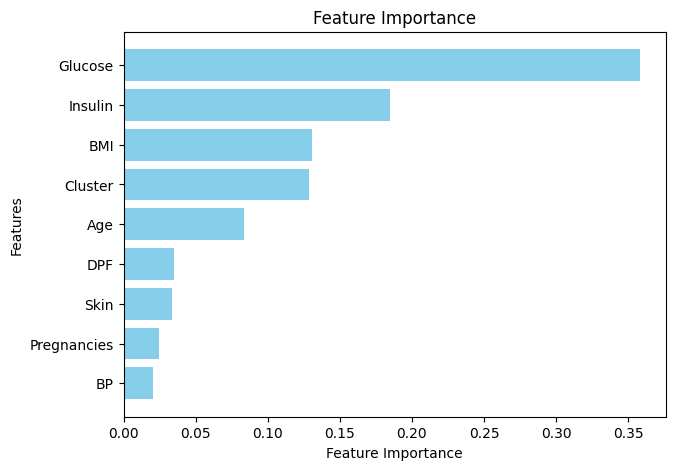

In [9]:
plot_eval.plot_best_model_feature_importance(best_params, best_pipeline,X_train, y_train, features) 

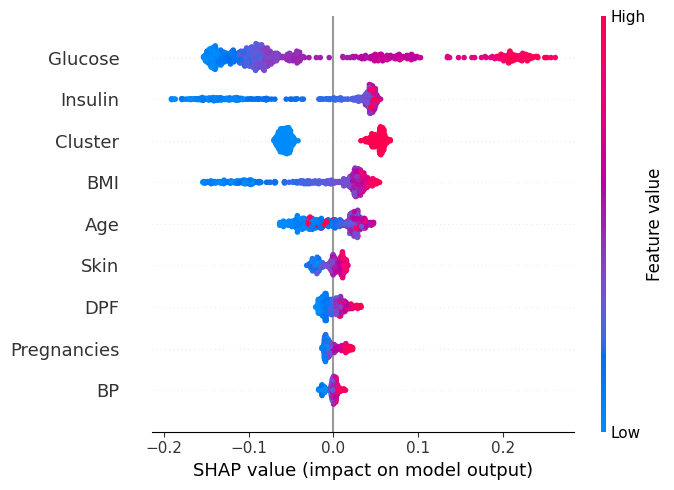

In [10]:
plot_eval.plot_shap_values_for_class_1(best_pipeline, X_train, y_train) # pos shap value means more likly to predict class "Diabetic"

### Discussion of Features

**Most Important Features**

- Glucose: High glucose values significantly influence the prediction, increasing the likelihood of being classified as "Diabetic."
- Insulin: Low insulin levels are the most impactful feature for predicting the "Not Diabetic" class.
- BMI (Body Mass Index): High BMI values tend to push the prediction towards the "Diabetic" class.
- Cluster Variable: The clustering feature (derived from KMeans clustering, n=2) plays a significant role in differentiating between the two classes. High cluster values tend to be associated with the "Diabetic" class, while lower values are more commonly linked to the "Not Diabetic" class.
- Age: Age is an important feature contributing to the likelihood of being diabetic. The middle range of age has the highest impact on predicting diabetes, with high age values contributing to a slightly lower likelihood of diabetes.


## 2. Final Evaluation on Test Data  
- The best-performing pipeline is applied to the **unseen test dataset** to assess its generalization ability.  
- Performance metrics are calculated to ensure the model works well in real-world scenarios.  


In [11]:
# Load data
data_test = pd.read_csv("../data/preprocessed_diabetes_test.csv")
X_test, y_test = data_test[features_org], data_test[target]

# predict y for X_test
y_pred = best_pipeline.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       150
           1       0.58      0.73      0.65        81

    accuracy                           0.72       231
   macro avg       0.71      0.72      0.71       231
weighted avg       0.74      0.72      0.73       231



#### Visualization of results

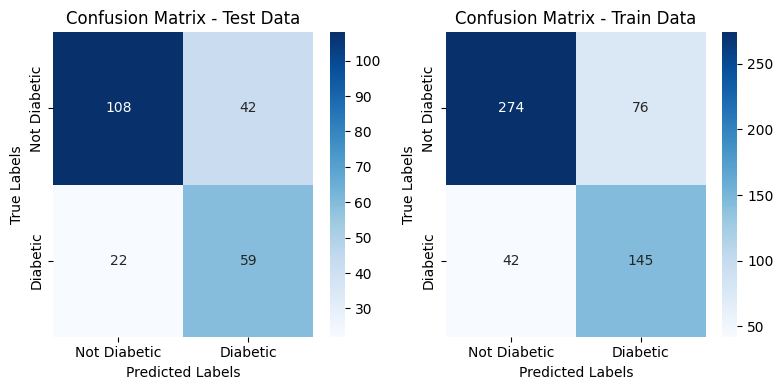

In [13]:
plot_eval.plot_confusion_matrix(best_pipeline, X_train, y_train, X_test, y_test)

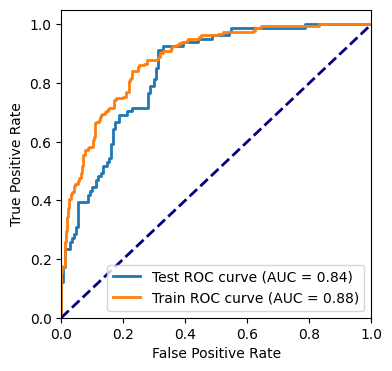

In [14]:
plot_eval.plot_roc_curve(best_pipeline, X_train, y_train, X_test, y_test)

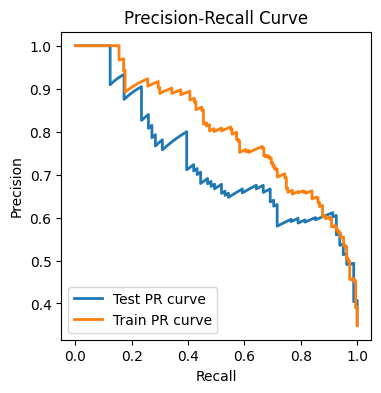

In [15]:
plot_eval.plot_precision_recall_curve(best_pipeline, X_train, y_train, X_test, y_test)

#### Evalution for different metrics


| Data       | Accuracy     | F1 Score     | ROC AUC   | Precision | Recall  |
|------------|--------------|--------------|-----------|-----------|---------|
| **Validation** | 0.7711 ± 0.0454 | 0.6956 ± 0.0575 | 0.8425 ± 0.0377 | --        | --      |
| **Test**       | 0.7229        | 0.6484        | 0.8412    | 0.5842    | 0.7284  |
| **Train**      | 0.7803        | 0.7108        | 0.8802    | 0.6561    | 0.7754  |




In [16]:
model_eval.evaluate_model_performance(best_pipeline, X_train, y_train, X_test, y_test)


Evaluation Metrics (Test Data):
Accuracy: 0.7229
F1 Score: 0.6484
ROC AUC: 0.8412
Precision: 0.5842
Recall: 0.7284

Evaluation Metrics (Train Data):
Accuracy: 0.7803
F1 Score: 0.7108
ROC AUC: 0.8802
Precision: 0.6561
Recall: 0.7754



#### Key Observation: Overfitting?

- **Performance Gap**: The model performs better on the **training set**, and **cross-validation** results exceed the test data by slighlty more than 1$\sigma$, except for ROC-AUC, which agrees well. 

#### Solutions:
- Perform **feature selection**.
- Try different **classifier models**.
- Optimize **hyperparameters** again for better generalization.

